In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.metrics import dtw
from tslearn.metrics import soft_dtw
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

### https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3
### https://towardsdatascience.com/time-series-clustering-deriving-trends-and-archetypes-from-sequential-data-bb87783312b4#:~:text=Time%20Series%20Clustering%20is%20an,and%20minimize%20it%20across%20clusters.

In [17]:
X = random_walks(n_ts=5, sz=30, d=2, mu=0., std=1.)
X

array([[[ 1.20587652e+00, -4.11673552e-01],
        [ 1.18475496e-01,  6.66701566e-01],
        [ 1.36552079e+00,  7.39519106e-02],
        [ 1.26849851e+00,  8.88515923e-01],
        [ 5.06153541e-01, -6.54870458e-01],
        [ 1.35037816e+00,  4.75734908e-01],
        [ 3.91941681e-01,  6.08761737e-01],
        [-1.14182273e+00, -9.63101813e-01],
        [-1.59145240e+00, -7.81528332e-01],
        [-2.92635090e+00, -1.89055593e+00],
        [-1.99735632e+00, -1.59437093e+00],
        [-1.99949298e+00, -2.65035315e+00],
        [-2.13913796e+00, -3.15286707e+00],
        [-1.12364490e+00, -2.85682857e+00],
        [-9.50124908e-01, -1.43019724e+00],
        [-3.74756140e+00, -5.74649923e-01],
        [-3.97151179e+00, -7.51779524e-01],
        [-3.98315487e+00, -1.89867863e+00],
        [-3.37273145e+00, -1.11382642e+00],
        [-3.13872908e+00, -1.72914848e+00],
        [-2.63395506e+00, -1.12746040e+00],
        [-3.50919387e+00, -1.48806033e+00],
        [-4.07339780e+00, -1.442

In [5]:
data = pd.read_csv("USEQ_raw_data.csv")
data.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
data

,Date,Credit Sussie Fear Barometer,SPX Forward CAPE Ratio,TSY Yield 3M,SPX FWD Yield,MXUS Index Divdend Yield,MXUS Index Debt to Equity,MXUS Index ROE,MXUS Index PE,SPX Volume,...,LME Copper Futures,ISM Non-Manufacturing PMI,Citi Economic Surprise Index US,Citi Economic Surprise Index Eurozone,Bloomberg Recession Probability Index,Bloomberg Commodity Metal Index,US Auto Sales,Bloomberg Eco US Surprise Index,TSY Yield 2Y,TSY Yield 10Y
0,2015-01-01,34.50,1.82,0.0355,45.15,2.01,108.47,14.64,18.7105,435587739.0,...,6255.0,56.2,28.3,9.0,10.0,180.15,16.66,0.059,0.666,2.172
1,2015-01-02,34.50,1.82,0.0152,45.15,2.01,108.43,14.64,18.7105,435587739.0,...,6255.0,56.2,28.3,9.0,10.0,180.15,16.66,0.059,0.667,2.111
2,2015-01-03,34.50,1.82,0.0152,45.15,2.01,108.43,14.64,18.7105,435587739.0,...,6255.0,56.2,28.3,9.0,10.0,180.15,16.66,0.059,0.667,2.111
3,2015-01-04,34.50,1.82,0.0152,45.15,2.01,108.43,14.64,18.7105,435587739.0,...,6255.0,56.2,28.3,9.0,10.0,180.15,16.66,0.059,0.667,2.111
4,2015-01-05,33.51,1.82,0.0101,45.20,2.05,108.44,14.64,18.3631,621869485.0,...,6145.0,56.2,27.6,12.4,10.0,177.78,16.66,0.025,0.659,2.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2788,2022-08-20,19.14,1.55,2.6451,69.92,1.51,114.39,19.92,21.2602,646495291.0,...,8078.5,56.7,-16.4,-51.4,50.0,237.88,13.35,-0.114,3.235,2.975
2789,2022-08-21,19.14,1.55,2.6451,69.92,1.51,114.39,19.92,21.2602,646495291.0,...,8078.5,56.7,-16.4,-51.4,50.0,237.88,13.35,-0.114,3.235,2.975
2790,2022-08-22,18.01,1.55,2.6962,69.89,1.54,114.39,19.92,20.8037,536127321.0,...,8027.0,56.7,-9.8,-49.9,50.0,238.34,13.35,-0.114,3.312,3.017
2791,2022-08-23,17.47,1.55,2.6694,69.87,1.54,114.39,19.92,20.7598,454368791.0,...,8120.0,56.7,-21.6,-45.8,50.0,239.59,13.35,-0.131,3.302,3.048


In [6]:
data = data.set_index('Date').T
data

Date,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,...,2022-08-15,2022-08-16,2022-08-17,2022-08-18,2022-08-19,2022-08-20,2022-08-21,2022-08-22,2022-08-23,2022-08-24
Credit Sussie Fear Barometer,34.5000,34.5000,34.5000,34.5000,33.5100,29.9200,29.5100,31.9300,33.1800,33.1800,...,18.6500,18.590,18.6900,19.200,19.1400,19.1400,19.1400,18.0100,17.4700,17.820
SPX Forward CAPE Ratio,1.8200,1.8200,1.8200,1.8200,1.8200,1.8200,1.8200,1.8200,1.8200,1.8200,...,1.5500,1.550,1.5500,1.550,1.5500,1.5500,1.5500,1.5500,1.5500,1.550
TSY Yield 3M,0.0355,0.0152,0.0152,0.0152,0.0101,0.0253,0.0203,0.0152,0.0152,0.0152,...,2.5371,2.587,2.6073,2.620,2.6451,2.6451,2.6451,2.6962,2.6694,2.736
SPX FWD Yield,45.1500,45.1500,45.1500,45.1500,45.2000,45.2100,45.1900,45.1900,45.2000,45.2000,...,69.8900,69.860,69.8500,69.900,69.9200,69.9200,69.9200,69.8900,69.8700,69.860
MXUS Index Divdend Yield,2.0100,2.0100,2.0100,2.0100,2.0500,2.0700,2.0500,2.0100,2.0300,2.0300,...,1.4800,1.480,1.4900,1.490,1.5100,1.5100,1.5100,1.5400,1.5400,1.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bloomberg Commodity Metal Index,180.1500,180.1500,180.1500,180.1500,177.7800,177.7600,177.2200,178.5800,177.8600,177.8600,...,238.6400,243.000,239.3300,239.150,237.8800,237.8800,237.8800,238.3400,239.5900,238.660
US Auto Sales,16.6600,16.6600,16.6600,16.6600,16.6600,16.6600,16.6600,16.6600,16.6600,16.6600,...,13.3500,13.350,13.3500,13.350,13.3500,13.3500,13.3500,13.3500,13.3500,13.350
Bloomberg Eco US Surprise Index,0.0590,0.0590,0.0590,0.0590,0.0250,-0.0060,-0.0040,-0.0170,-0.0310,-0.0310,...,-0.1670,-0.175,-0.1580,-0.114,-0.1140,-0.1140,-0.1140,-0.1140,-0.1310,-0.157
TSY Yield 2Y,0.6660,0.6670,0.6670,0.6670,0.6590,0.6270,0.6110,0.6070,0.5630,0.5630,...,3.1850,3.262,3.2860,3.201,3.2350,3.2350,3.2350,3.3120,3.3020,3.392


In [7]:
anarray= data.to_numpy()
#anarray.shape
anarray= TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(anarray)
sz = anarray.shape[1]
sz

2793

In [8]:
km_dba = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=5,max_iter_barycenter=5,random_state=0, n_jobs=-1).fit(anarray)

In [9]:
y_pred = km_dba.labels_
y_pred

array([0, 0, 3, 3, 0, 3, 3, 3, 2, 1, 0, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1,
       0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3,
       0, 3, 0, 3, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 0, 3, 3, 1],
      dtype=int64)

In [10]:
silhouette_score(anarray, km_dba.labels_, metric="dtw", n_jobs=-1)

0.2264039298120897

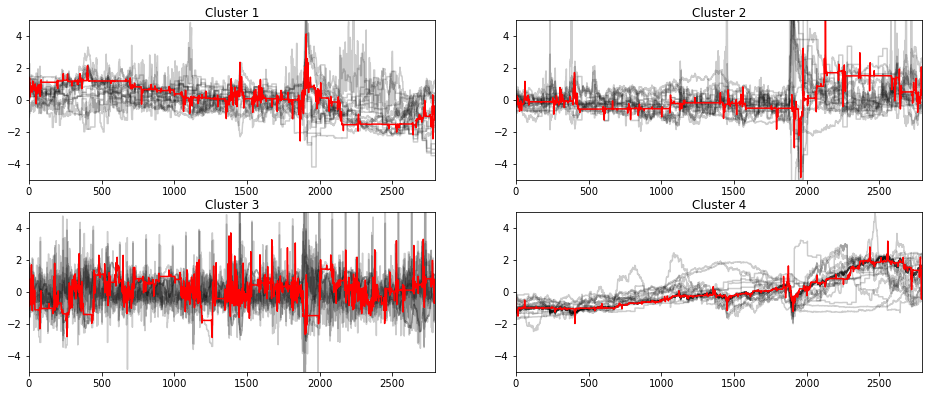

In [11]:
plt.figure(figsize=(16,10))
for yi in range(4):
    plt.subplot(3, 2, 1 + yi)
    for xx in anarray[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km_dba.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-5, 5)
    plt.title('Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)

In [12]:
#need to implement the code for the pairwise distance matrix and then use the metric "precomputed"
sample_silhouette_values = silhouette_samples(anarray.reshape(64,2793), y_pred, metric='euclidean') 
means_lst = []
for label in range(4):
    means_lst.append(sample_silhouette_values[y_pred == label].mean())

In [74]:
test = anarray.reshape(64,2793)
test.shape

(64, 2793)

In [77]:
means_lst

[0.1390210649649482,
 -0.03691307111636993,
 -0.026001005311625323,
 0.3735030115512737]

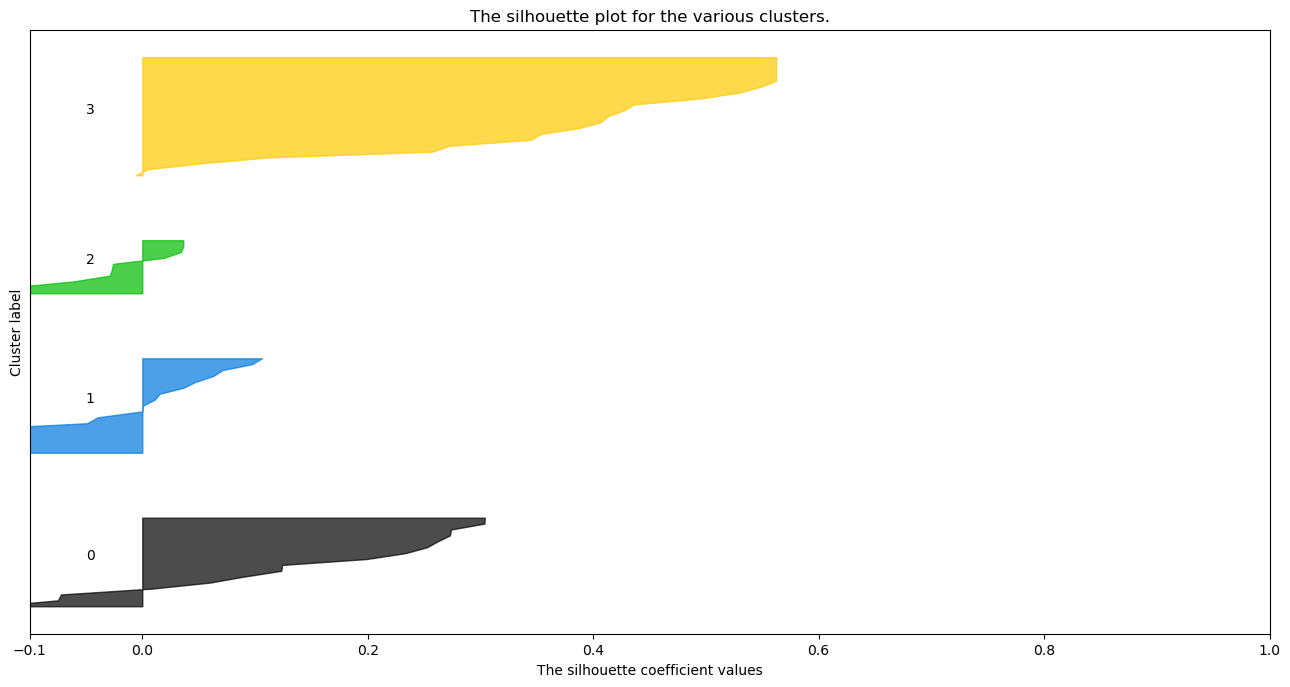

In [23]:
figure4 = plt.Figure(figsize=(16,8), dpi=100)
ax1 = figure4.add_subplot()
ax1.set_xlim([-0.1, 1])
#ax1.set_ylim([0, len(X_array) + (labels_array['labels'].max() + 1) * 10])
y_lower = 10
for i in range(0, y_pred.max()+1):

    ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / (y_pred.max()+1))
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

#ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
#ax1.text(.75, y_upper*0.5, f"Average Silhouette Score\n {silhouette_avg}", fontsize=15)
ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
figure4